## **실습 진행 부분**

## **실습을 진행하셔야 과제 진행을 할 수 있습니다.**


## kaggle API 연동


In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sjh1004","key":"12609c80505a99e6669f50cf678b3fd2"}'}

In [3]:
!ls -1ha kaggle.json

kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list

ref                                             deadline             category            reward  teamCount  userHasEntered  
----------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                    2030-07-01 23:59:00  Getting Started     Prizes         60           False  
gan-getting-started                             2030-07-01 23:59:00  Getting Started     Prizes         90           False  
store-sales-time-series-forecasting             2030-06-30 23:59:00  Getting Started  Knowledge        715           False  
tpu-getting-started                             2030-06-03 23:59:00  Getting Started  Knowledge        135           False  
digit-recognizer                                2030-01-01 00:00:00  Getting Started  Knowledge       1243           False  
titanic                                         2030-01-01 00:00:00  Getting Started  Knowledge      14377           False  


In [5]:
!kaggle datasets download -d mahmoudreda55/satellite-image-classification

 96% 21.0M/21.8M [00:02<00:00, 18.6MB/s]
100% 21.8M/21.8M [00:02<00:00, 11.1MB/s]


In [6]:
!unzip train.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: data/cloudy/train_23566.jpg  
  inflating: data/cloudy/train_23598.jpg  
  inflating: data/cloudy/train_23608.jpg  
  inflating: data/cloudy/train_23634.jpg  
  inflating: data/cloudy/train_23636.jpg  
  inflating: data/cloudy/train_23646.jpg  
  inflating: data/cloudy/train_2366.jpg  
  inflating: data/cloudy/train_23664.jpg  
  inflating: data/cloudy/train_23706.jpg  
  inflating: data/cloudy/train_2380.jpg  
  inflating: data/cloudy/train_23805.jpg  
  inflating: data/cloudy/train_23806.jpg  
  inflating: data/cloudy/train_23826.jpg  
  inflating: data/cloudy/train_23843.jpg  
  inflating: data/cloudy/train_23877.jpg  
  inflating: data/cloudy/train_23884.jpg  
  inflating: data/cloudy/train_23953.jpg  
  inflating: data/cloudy/train_2396.jpg  
  inflating: data/cloudy/train_23978.jpg  
  inflating: data/cloudy/train_23979.jpg  
  inflating: data/cloudy/train_23980.jpg  
  inflating: data/cloudy/train_23981.jpg  
  inflating: data/clo

## Custom DataSet Loader


In [7]:
import torch
from torch.utils.data import Dataset
import numpy as np
import os
import cv2
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split

In [8]:
# function collection and variable

def get_labels(data_path):
  return os.listdir(data_path)

def check_image_count(label, data_path):
  print("{} count : {}".format(label,len(os.listdir(data_path))))

image_size = (112,112)

In [9]:
DATA_FOLDER = 'data'

label_mapper = {}


# check data code
def check_data(data_path):
    labels = os.listdir(data_path)
    for label in labels:
        folder_path = os.path.join(data_path, label)
        check_image_count(label,folder_path)

check_data(DATA_FOLDER)
    
def make_excel_data(data_path):
    image_data = []
    labels = os.listdir(data_path)
    for index, label in enumerate(labels):
        folder_path = os.path.join(data_path, label)
        image_list = os.listdir(folder_path)
        label_mapper[label] = index
        for image in tqdm(image_list):
            data_row = []
            image_path = os.path.join(folder_path, image)
            image_shape = cv2.imread(image_path).shape
            data_row.append(image_path)
            data_row.append(label)
            image_data.append(data_row)
    return image_data
          
image_data = make_excel_data(DATA_FOLDER)

water count : 1500
cloudy count : 1500
desert count : 1131
green_area count : 1500


100%|██████████| 1500/1500 [00:00<00:00, 8888.17it/s]


In [10]:
label_mapper

{'water': 0, 'cloudy': 1, 'desert': 2, 'green_area': 3}

In [11]:
def generate_csv(image_data):
    columns = ['path', 'label']
    image_data = np.array(image_data)
    train_dataset, test_dataset = train_test_split(image_data, test_size=0.2, random_state= 42)
    print(train_dataset.shape, test_dataset.shape)
    df = pd.DataFrame(train_dataset, columns= columns)
    df.to_csv('train.csv')
    df2 = pd.DataFrame(test_dataset, columns= columns)
    df.to_csv('test.csv')
generate_csv(image_data)

(4504, 2) (1127, 2)


In [12]:
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file,names=['path', 'label'],header=1)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        
        img_path = self.img_labels.iloc[idx, 0]
        image = cv2.imread(img_path)
        label = self.img_labels.iloc[idx, 1]
        if label == 'label':
            return None, None
        label = label_mapper[label]
        
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        return image, label

In [13]:
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((112, 112)),
    transforms.ToTensor()])

dataset = CustomImageDataset('train.csv',transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

testdataset = CustomImageDataset('test.csv',transform)
testdataloader = DataLoader(testdataset, batch_size=8, shuffle=True)

Feature batch shape: torch.Size([8, 3, 112, 112])
Labels batch shape: torch.Size([8])


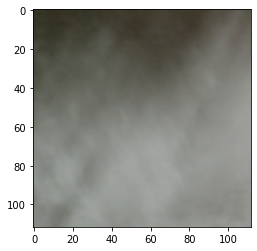

Label: 1


In [14]:
import matplotlib.pyplot as plt
train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.permute(2,1,0))
plt.show()
print(f"Label: {label}")



## **과제 수행 부분** 
## ResNet 18 구현


In [15]:
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
	# mul은 추후 ResNet18, 34, 50, 101, 152등 구조 생성에 사용됨
    mul = 1
    # in_planes 입력 채널
    # out_planes 출력 채널
    def __init__(self, in_planes, out_planes, stride=1):
        super(BasicBlock, self).__init__()

        # PPT 그림 참고하여 어떤 식으로 설계할 지 구현
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, padding=1, stride=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()

        # 만약 size가 안맞아 합연산이 불가하다면, 연산 가능하도록 모양을 맞춰줌
        if stride != 1: # x와 
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [16]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        #RGB 3개채널에서 64개의 Kernel 사용 (논문 참고)
        self.in_planes = 64
        
        # Resnet 논문 구조의 conv1 파트 그대로 구현
        """
        todo 처음 2개 블럭 쌓기
        """
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=7, padding=3, stride=2, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        
        # Basic Resiudal Block일 경우 그대로, BottleNeck일 경우 4를 곱한다.
        self.linear = nn.Linear(512 * block.mul, num_classes)
        
    # 다양한 Architecture 생성을 위해 make_layer로 Sequential 생성     
    def make_layer(self, block, out_planes, num_blocks, stride):
        # layer 앞부분에서만 크기를 절반으로 줄이므로, 아래와 같은 구조
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for i in range(num_blocks):
            layers.append(block(self.in_planes, out_planes, strides[i]))
            self.in_planes = block.mul * out_planes
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.maxpool1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out,1)
        out = self.linear(out)
        return out

In [17]:
# 바꾸시면 안됩니다.

def ResNet18(classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], classes)

In [18]:
Model = ResNet18(4)

In [19]:
import torch.optim as optim

In [20]:
gpu_model = Model
# 손실함수 선언
criterion = nn.CrossEntropyLoss()
# 옵티마이저 선언
optimizer = optim.SGD(gpu_model.parameters(), lr=0.001, momentum=0.9)

# 5에포크 실행
for epoch in range(5):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        
        inputs, labels = data[0].to('cuda'), data[1].to('cuda')
        if labels == None:
            continue
        # # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        gpu_model = gpu_model.to('cuda')
        outputs = gpu_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.802
[1,   400] loss: 0.553
[2,   200] loss: 0.497
[2,   400] loss: 0.492
[3,   200] loss: 0.444
[3,   400] loss: 0.454
[4,   200] loss: 0.408
[4,   400] loss: 0.440
[5,   200] loss: 0.395
[5,   400] loss: 0.349
Finished Training


In [21]:
correct = 0
total = 0


for data in testdataloader:
    images, labels = data[0].to('cuda'), data[1].to('cuda')
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
    gpu_model = gpu_model.to('cuda')
    outputs = gpu_model(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 85 %


In [22]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in list(label_mapper.keys())}
total_pred = {classname: 0 for classname in list(label_mapper.keys())}

print(correct_pred)
print(total_pred)

label_reverse_mapper = {}
label_reverse_mapper['0'] = 'green_area'
label_reverse_mapper['1'] = 'desert'
label_reverse_mapper['2'] = 'water'
label_reverse_mapper['3'] = 'cloudy'

for data in testdataloader:
    images, labels = data[0].to('cuda'), data[1].to('cuda')

    gpu_model = gpu_model.to('cuda')
    outputs = gpu_model(images)
    _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
    for label, prediction in zip(labels, predictions):
        if label == prediction:
            correct_pred[label_reverse_mapper[str(label.item())]] += 1
        total_pred[label_reverse_mapper[str(label.item())]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

{'water': 0, 'cloudy': 0, 'desert': 0, 'green_area': 0}
{'water': 0, 'cloudy': 0, 'desert': 0, 'green_area': 0}
Accuracy for class: water is 91.7 %
Accuracy for class: cloudy is 76.9 %
Accuracy for class: desert is 90.9 %
Accuracy for class: green_area is 84.0 %
